# Yoga Pose Classification using Neural Networks

This notebook implements a complete pipeline for Yoga Pose detection and classification.
It includes:
1. **Data Acquisition**: Downloading the dataset.
2. **Feature Extraction**: Using MediaPipe Pose to extract skeletal landmarks and calculating joint angles.
3. **Data Preprocessing**: Robust handling of missing data (preventing leakage), scaling, and encoding.
4. **Model Development**: Building and training a Multi-Layer Perceptron (MLP).
5. **Evaluation**: assessing performance on a hold-out test set.

**Author:** Antigravity (Refactored)


After running this cell, a download prompt should appear in your browser, allowing you to save the `content_colab.zip` file to your local drive.

Remember to replace `folder_to_zip` with the actual path to the folder you wish to download. For instance, if you want to download the entire dataset, you can use the `path` variable from `a1HAYl_NvFQ8` which is `/root/.cache/kagglehub/datasets/gendubali/47-yoga-pose-detection/versions/2`.

In [1]:
!pip install mediapipe
# --- Standard Library ---
import os
import random
import warnings

# --- Third Party ---
import cv2
import joblib
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.utils import to_categorical
from tqdm.auto import tqdm

# --- MediaPipe New Tasks API ---
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# --- Configuration ---
warnings.filterwarnings('ignore')
SEED = 42
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)
print("Libraries installed and seed set.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
Libraries installed and seed set.


In [2]:
# --- Helper Functions ---

def calculate_angle(a, b, c):
    """Calculates the angle at point b given points a, b, and c."""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

def extract_features_from_image_robust(image_path, landmarker, visibility_threshold=0.5):
    """
    Extracts pose landmarks and calculates angles using the new MediaPipe PoseLandmarker API.
    """
    try:
        # Load image via OpenCV
        image = cv2.imread(image_path)
        if image is None:
            return None

        # Convert to MediaPipe Image Object (New API Requirement)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

        # Detect
        detection_result = landmarker.detect(mp_image)

        # Check if any pose was detected
        if not detection_result.pose_landmarks:
            return None

        # Get the first detected person's landmarks
        # The new API returns a list of lists (one list per person)
        landmarks = detection_result.pose_landmarks[0]

        features = {}

        # 1. Extract raw coordinates (x, y, z, visibility)
        # Note: In the new NormalizedLandmark object, attributes are x, y, z, visibility, presence
        for i, lm in enumerate(landmarks):
            features[f'landmark_{i}_x'] = lm.x
            features[f'landmark_{i}_y'] = lm.y
            features[f'landmark_{i}_z'] = lm.z
            features[f'landmark_{i}_v'] = lm.visibility

        # 2. Extract specific landmarks for Angle Calculation
        # We map the index manually since the old enum might belong to the legacy solution
        # However, the indices standard is usually 0-32.
        # 11=left_shoulder, 12=right_shoulder, etc.

        # Define indices map based on standard BlazePose topology
        IDX = {
            'right_shoulder': 12, 'right_elbow': 14, 'right_wrist': 16,
            'right_hip': 24,      'right_knee': 26,  'right_ankle': 28,
            'left_shoulder': 11,  'left_elbow': 13,  'left_wrist': 15,
            'left_hip': 23,       'left_knee': 25,   'left_ankle': 27
        }

        def get_coords(index):
            lm = landmarks[index]
            # Verify visibility if needed, or return None
            return [lm.x, lm.y, lm.z] if lm.visibility > visibility_threshold else None

        # Collect necessary joint coordinates
        joints = {name: get_coords(idx) for name, idx in IDX.items()}

        # Angles to calculate (joint_name: [point_a, point_b, point_c])
        angle_defs = {
            'angle_right_elbow': ('right_shoulder', 'right_elbow', 'right_wrist'),
            'angle_left_elbow': ('left_shoulder', 'left_elbow', 'left_wrist'),
            'angle_right_shoulder': ('right_hip', 'right_shoulder', 'right_elbow'),
            'angle_left_shoulder': ('left_hip', 'left_shoulder', 'left_elbow'),
            'angle_right_hip': ('right_shoulder', 'right_hip', 'right_knee'),
            'angle_left_hip': ('left_shoulder', 'left_hip', 'left_knee'),
            'angle_right_knee': ('right_hip', 'right_knee', 'right_ankle'),
            'angle_left_knee': ('left_hip', 'left_knee', 'left_ankle')
        }

        for angle_name, (a, b, c) in angle_defs.items():
            if joints[a] and joints[b] and joints[c]:
                features[angle_name] = calculate_angle(joints[a], joints[b], joints[c])
            else:
                features[angle_name] = np.nan # Explicitly mark as missing

        return features

    except Exception as e:
        # print(f"Error processing {image_path}: {e}")
        return None


In [3]:
# --- Download Model and Process Dataset ---
DATA_DIR = 'yoga_dataset_raw'
CSV_OUTPUT_PATH = 'yoga_pose_features.csv'
MODEL_PATH = 'pose_landmarker_heavy.task'

# 1. Download the Heavy Pose Model (New API requirement)
if not os.path.exists(MODEL_PATH):
    print("Downloading MediaPipe Pose Landmarker Model...")
    # Using curl or wget
    !wget -O pose_landmarker_heavy.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
    print("Model downloaded.")
else:
    print(f"Model {MODEL_PATH} already exists.")

# Check if we need to download/process or if we can reload
PROCESS_DATA = True

if os.path.exists(CSV_OUTPUT_PATH):
    print(f"Stats file '{CSV_OUTPUT_PATH}' already exists.")
    user_input = input("Do you want to re-process the dataset? (y/n): ").strip().lower()
    if user_input != 'y':
        PROCESS_DATA = False

if PROCESS_DATA:
    print("Downloading dataset content...")
    path = kagglehub.dataset_download("gendubali/47-yoga-pose-detection")
    print("Path to dataset files:", path)

    # --- Initialize Pose Landmarker (New API) ---
    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    # Create options with the model file
    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=MODEL_PATH),
        running_mode=VisionRunningMode.IMAGE,
        min_pose_detection_confidence=0.5,
        min_pose_presence_confidence=0.5,
        min_tracking_confidence=0.5
    )

    # Create the detector using a context manager to ensure it closes
    print("Initializing Pose Landmarker...")
    with PoseLandmarker.create_from_options(options) as landmarker:

        all_features = []
        class_folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

        print(f"Found {len(class_folders)} classes.")

        for class_name in tqdm(class_folders, desc="Processing Classes"):
            class_path = os.path.join(path, class_name)

            # Limit samples per class if needed for testing (e.g., [:500])
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            # Process images
            for image_name in image_files:
                image_path = os.path.join(class_path, image_name)

                # Pass the landmarker instance
                features = extract_features_from_image_robust(image_path, landmarker)

                if features:
                    features['image_path'] = image_path
                    features['yoga_pose'] = class_name
                    all_features.append(features)

        # Save results
        if all_features:
            df = pd.DataFrame(all_features)
            df.to_csv(CSV_OUTPUT_PATH, index=False)
            print(f"Saved extracted features to {CSV_OUTPUT_PATH}")
        else:
            print("No features extracted!")

else:
    df = pd.read_csv(CSV_OUTPUT_PATH)
    print("Loaded dataset from CSV.")

print(f"Dataset Shape: {df.shape}")
df.head()


Model downloaded.


100%|██████████| 637M/637M [00:22<00:00, 30.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gendubali/47-yoga-pose-detection/versions/2
Initializing Pose Landmarker...
Found 47 classes.


Processing Classes:   0%|          | 0/47 [00:00<?, ?it/s]

Saved extracted features to yoga_pose_features.csv
Dataset Shape: (47880, 142)


,landmark_0_x,landmark_0_y,landmark_0_z,landmark_0_v,landmark_1_x,landmark_1_y,landmark_1_z,landmark_1_v,landmark_2_x,landmark_2_y,...,angle_right_elbow,angle_left_elbow,angle_right_shoulder,angle_left_shoulder,angle_right_hip,angle_left_hip,angle_right_knee,angle_left_knee,image_path,yoga_pose
0,0.452780,0.834438,-0.373968,0.998112,0.479969,0.830513,-0.357426,0.997455,0.480740,0.828272,...,104.289559,NaN,170.998644,NaN,91.861676,NaN,NaN,NaN,/root/.cache/kagglehub/datasets/gendubali/47-y...,Pincha Mayurasana
1,0.114732,0.817584,-0.363621,0.989467,0.103901,0.798799,-0.391960,0.994536,0.105312,0.795648,...,NaN,166.680451,NaN,164.927091,NaN,164.074167,NaN,175.947872,/root/.cache/kagglehub/datasets/gendubali/47-y...,Pincha Mayurasana
2,0.344645,0.808446,-0.137416,0.999892,0.331373,0.815642,-0.169179,0.999903,0.329845,0.814623,...,NaN,143.153736,NaN,157.940549,NaN,164.293600,NaN,171.901548,/root/.cache/kagglehub/datasets/gendubali/47-y...,Pincha Mayurasana
3,0.388020,0.779694,0.012983,0.999740,0.404000,0.775509,0.025150,0.999472,0.405164,0.773552,...,78.146440,NaN,172.718866,NaN,86.384747,NaN,46.524681,NaN,/root/.cache/kagglehub/datasets/gendubali/47-y...,Pincha Mayurasana
4,0.599793,0.751356,-0.081734,0.999200,0.619989,0.757531,-0.085487,0.997488,0.623357,0.754517,...,118.181327,NaN,154.149112,NaN,79.788498,NaN,175.992159,NaN,/root/.cache/kagglehub/datasets/gendubali/47-y...,Pincha Mayurasana


In [4]:
# --- Data Preprocessing Pipeline (Corrected for Leakage) ---

# 1. Load Data
# Re-load to ensure fresh start if we skipped processing block
df = pd.read_csv(CSV_OUTPUT_PATH)

# Optional: Filter out noisy classes if needed
df = df[df["yoga_pose"] != "Alanasana"]

X = df.drop(columns=['image_path', 'yoga_pose'])
y = df['yoga_pose']

print(f"Total samples: {len(X)}")

# 2. Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save Label Encoder
joblib.dump(label_encoder, "label_encoder.pkl")

# Convert to One-Hot
num_classes = len(label_encoder.classes_)
y_cat = to_categorical(y_encoded, num_classes=num_classes)

# 3. Split Data (Train/Val/Test) BEFORE Imputation/Scaling
# This prevents data leakage (using test set stats to clean train set)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.2, random_state=SEED, stratify=y_cat)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

print(f"Train Clean: {X_train.shape}")
print(f"Val Clean:   {X_val.shape}")
print(f"Test Clean:  {X_test.shape}")

# 4. Impute Missing Values
# We fit the imputer ONLY on the training set
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Save Imputer
joblib.dump(imputer, "col_means.pkl") # Naming it col_means to match user preference, but it is an imputer object

# 5. Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Save Scaler
joblib.dump(scaler, "scaler.pkl")

print("Preprocessing complete. Artifacts saved.")


Total samples: 46761
Train Clean: (37408, 140)
Val Clean:   (4676, 140)
Test Clean:  (4677, 140)
Preprocessing complete. Artifacts saved.


In [5]:
# --- Model Architecture ---
input_dim = X_train_scaled.shape[1]

model = Sequential([
    InputLayer(shape=(input_dim,)),

    Dense(512, activation='gelu'),
    Dropout(0.3),

    Dense(256, activation='gelu'), # Reduced slightly for better pyramid
    Dropout(0.3),

    Dense(128, activation='gelu'),
    Dropout(0.2),

    Dense(64, activation='gelu'),

    Dense(num_classes, activation='softmax')
])

optimizer = Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-7)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_yoga_model.keras', monitor='val_accuracy', save_best_only=True, verbose=0)
]

# --- Training ---
history = model.fit(
    X_train_scaled, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks,
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,662 (967.43 KB)

 Trainable params: 247,662 (967.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
585/585 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2566 - loss: 2.8217 - val_accuracy: 0.5539 - val_loss: 1.6902
Epoch 2/150
585/585 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5126 - loss: 1.8061 - val_accuracy: 0.5873 - val_loss: 1.4952
Epoch 3/150
585/585 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5587 - loss: 1.6272 - val_accuracy: 0.6144 - val_loss: 1.4136
Epoch 4/150
585/585 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5812 - loss: 1.5411 - val_accuracy: 0.6302 - val_loss: 1.3516
Epoch 5/150
585/585 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5966 - loss: 1.4704 - val_accuracy: 0.6424 - val_loss: 1.3038
Epoch 6/150
585/585 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6137 - loss: 1.4154 - val_accuracy: 0.6473 - val_loss: 1.2758
Epoch 7/150
585/585 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6199 - loss: 1.3755 - val_accuracy: 0.6587 - val_loss: 1.2482
Epoch 8/150
585/585 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6311 - loss: 1.3375 -


Test Accuracy: 74.39%
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:

                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.71      0.75      0.73       113
         Adho Mukha Vrksasana       0.64      0.69      0.66       103
                 Anjaneyasana       0.61      0.58      0.59       121
            Ardha Chandrasana       0.92      0.81      0.86       123
         Ardha Matsyendrasana       0.72      0.85      0.78       115
               Ardha Navasana       0.57      0.55      0.56        69
      Ardha Pincha Mayurasana       0.71      0.64      0.67       102
            Ashta Chandrasana       0.58      0.65      0.62        86
              Baddha Konasana       0.77      0.78      0.78       119
                     Bakasana       0.77      0.89      0.83       122
                     Balasana       0.69      0.79      0.73       100
                   Bitilasana       0.76      0.55      0.

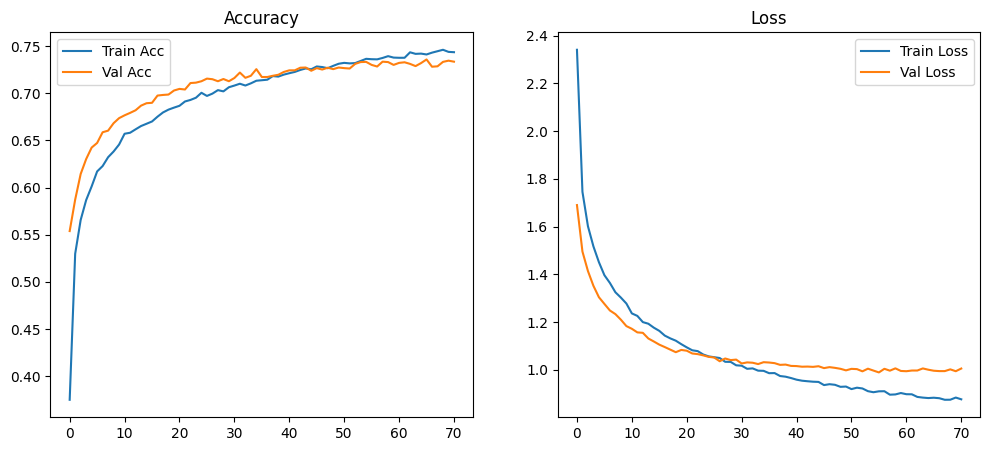

In [6]:
# --- Evaluation ---

# Load best model
best_model = load_model('best_yoga_model.keras')

# Evaluate on Test Set
test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Detailed Report
y_pred_probs = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()
